In [1]:
import numpy as np
from pyvbmc import VBMC 
from pyvbmc.priors import SplineTrapezoidal
from scipy.integrate import solve_ivp
import sympy as sym
from pyvbmc.acquisition_functions import AcqFcnLog, AcqFcnNoisy, AcqFcnVIQR, AcqFcnIMIQR, AcqFcnVanilla

# variables setup
m1,m2,m3,k1,k2,k3,k4,time = sym.symbols('m_1,m_2,m_3,k_1,k_2,k_3,k_4,t')
x1 = sym.Function(r'\x_1')(time)
x2 = sym.Function(r'\x_2')(time)
x3 = sym.Function(r'\x_3')(time)
x1d = x1.diff(time)
x2d = x2.diff(time)
x3d = x3.diff(time)
x1dd = x1.diff(time,2)
x2dd = x2.diff(time,2)
x3dd = x3.diff(time,2)

# Lagrangian Setup
T = 0.5 * (k1 * x1**2 + k2 * (x1 - x2)**2 + k3 * (x2 - x3)**2 + k4 * x3**2)
V =  0.5 * (m1* x1d **2 + m2 * x2d**2 + m3 * x3d **2)
L = T - V

# Get EOMs from Euler-Lagrange Equation:
left = L.diff(x1)
right = L.diff(x1d).diff(time)
x1dd = sym.solve(sym.Eq(left,right),x1dd)

left1 = L.diff(x2)
right1 = L.diff(x2d).diff(time)
x2dd = sym.solve(sym.Eq(left1,right1),x2dd)

left2 = L.diff(x3)
right2 = L.diff(x3d).diff(time)
x3dd = sym.solve(sym.Eq(left2,right2),x3dd)

x1dd_f = sym.lambdify([m1,m2,m3,k1,k2,k3,k4,x1,x2,x3],x1dd,'numpy')
x2dd_f = sym.lambdify([m1,m2,m3,k1,k2,k3,k4,x1,x2,x3],x2dd,'numpy')
x3dd_f = sym.lambdify([m1,m2,m3,k1,k2,k3,k4,x1,x2,x3],x3dd,'numpy')

# EOMs
def derivs(t,curr_vals,m1,m2,m3,k1,k2,k3,k4):

    x1,x1d,x2,x2d,x3,x3d = curr_vals

    return x1d, x1dd_f(m1,m2,m3,k1,k2,k3,k4,x1,x2,x3)[0], x2d, x2dd_f(m1,m2,m3,k1,k2,k3,k4,x1,x2,x3)[0], x3d, x3dd_f(m1,m2,m3,k1,k2,k3,k4,x1,x2,x3)[0]

# parameters and initial conditions
initial1 = [0,1,0,0,0,0]
initial2 = [1,0,0,-0.2,3.5,0]
initial3 = [0,1,1,-0.5,0,-0.2]
initial4 = [3,3,1,-0.5,-1,-0.5]
initial_conditions = [initial1,initial2,initial3,initial4]
noise_sigma = 0.03
sigma = noise_sigma
tmax = 10
dt = 0.05
t = np.arange(0,tmax,dt)
m1 = 1.
m2 = 1.
m3 = 1.

def log_likelihood(theta):
    k1,k2,k3,k4 = theta
    sols = []
    for initial_condition in initial_conditions:
        sol = solve_ivp(derivs,(0,tmax),initial_condition,t_eval = t, args = (m1,m2,m3,k1,k2,k3,k4), method = "LSODA").y
        sols.append(np.array([sol[i] for i in [0,2,4]]))
    big_sol = np.concatenate(sols, axis = 1)
    sliced_sol = big_sol[:,0::4]
    return np.sum(np.log(1/(sigma* (2*np.pi)**0.5))-(0.5/sigma**2) * (y_true - sliced_sol)**2)

D = 4
LB = np.full((1, D), 0.0)
UB = np.full((1, D), 50.0)
PLB = np.full((1, D), 0.1)
PUB = np.full((1, D), 10.0)
x0 = 1.2 * np.ones((1, D))

prior = SplineTrapezoidal(LB, PLB, PUB, UB)

options = {
    "display": "off",
    "max_fun_evals": 500,
    "search_acq_fcn": []
}

seeds = np.arange(10)
acquisition_functions = [AcqFcnLog(), AcqFcnNoisy(), AcqFcnVIQR(), AcqFcnIMIQR(), AcqFcnVanilla()]
for i, acq in enumerate(acquisition_functions):
    options["search_acq_fcn"] = [acq]
    k1 = 1.
    k2 = 1.
    k3 = 1.
    k4 = 1.
    for j in range(1,4):
        sols = []
        for initial_condition in initial_conditions:
            sol = solve_ivp(derivs,(0,tmax),initial_condition,t_eval = t, args = (m1,m2,m3,k1,k2,k3,k4), method = "LSODA").y
            sols.append(np.array([sol[i] for i in [0,2,4]]))
        big_t = np.arange(0,4*tmax,dt)
        big_sol = np.concatenate(sols, axis = 1)
        y_true = big_sol[:,0::4]

        for seed in seeds:
            np.random.seed(seed)
            x0 = np.random.uniform(PLB,PUB)
            np.random.seed(seed) 
            vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options)
            np.random.seed(seed)
            vp, results = vbmc.optimize();
            vbmc.vp.save("vp" + str(i) + "_" +  str(j) + "_" + str(seed) + ".pkl", overwrite=True)
        k1 += 1.
        k2 += 1.
        k3 += 1.
        k4 += 1.

c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3823: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range = max(es.fit.fit) - min(es.fit.fit)
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: -205157.681 +/-8349.784.
Caution: Returned variational solution may have not converged.


: 

: 

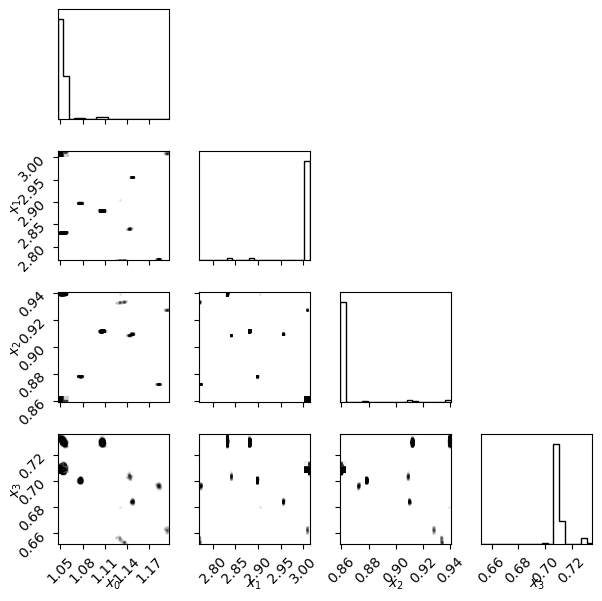

In [5]:
from pyvbmc import VariationalPosterior
vp = VariationalPosterior.load("vp0_1_0.pkl")
vp.plot();

In [6]:
vp.moments()

array([[1.05492163, 3.00447156, 0.86314697, 0.71046527]])